## Команда Dark Brotherhood

In [366]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from catboost import CatBoostClassifier
from sklearn.ensemble import IsolationForest
from prophet import Prophet
import yake

from tqdm.notebook import tqdm
tqdm.pandas()

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#обработка текста
import nltk
#nltk.download('stopwords')
import spacy
#python -m spacy download ru_core_news_md

#загружаем текстовые модели
stopwords_nltk = nltk.corpus.stopwords.words('russian')  #лист русский стоп-слов
stopwords_nltk_en = nltk.corpus.stopwords.words('english')
stopwords_nltk.extend(stopwords_nltk_en)  #часть текста а английском

lemmatizer = spacy.load('ru_core_news_md', disable = ['parser', 'ner'])

Дополнительные функции для обработки датасета

In [251]:
# очищаем текст от мусора
def full_clean(s):
    #подготовка текста к подаче в модель
    #удалим специальные символы, цифры (0-9), знаки пунктуации, приведем к строчным буквам
    #оставим русские и английские буквы
    s=re.sub(r"[^a-zA-Zа-яА-Я#]", " ", s)  
    s = s.lower() #все в нижний регистр
    s = re.sub(" +", " ", s) #оставляем только 1 пробел
    text = " ".join([token.lemma_ for token in lemmatizer(s) if token.lemma_ not in stopwords_nltk])
    
    return text


def cats_featuring(train, test):
    #не понятно, что обозначают 'Сервис', 'Система', 'Функциональная группа' и 'Место'
    #система и сервис сильно коррелируют - вероятно это операционная система и ее функции
    #приоритет связан с критичнгостью - это и так понятно, в остальных связь слабая
    cats_col = ['Сервис', 'Система', "Критичность", "Влияние", "Приоритет", "Тип обращения на момент подачи",
            "Статус", 'Место', "Тип обращения итоговый", 'Тип переклассификации']
    test_cats = ['Сервис', 'Система', "Критичность", "Влияние", "Приоритет", "Тип обращения на момент подачи",
             "Статус", 'Место']

    cleanup_parts = {"Сервис": {"АРМ": "0", "Сервис": ''},
                 "Система": {"База": "0", "Система": ''}}

    cleanup_cats = {"Критичность": {"4-Нет": 4, "3-Базовая": 3, "2-Повышенная": 2, "1-Особая": 1},
                "Влияние": {"4-Нет влияния": 4, "3-Малое": 3, "2-Значительное": 2, "1-Всеохватывающее": 1},
                "Приоритет": {"3-Низкий": 4, "2-Средний": 3, "1-Высокий": 2, "0-Критический": 1},
                "Тип обращения на момент подачи": {"Запрос": 1, "Инцидент": 0},
                "Тип обращения итоговый": {"Запрос": 1, "Инцидент": 0},
                "Статус": {"Отменен": 1, "Закрыт": 0}}
    
    #Кодируем Функциональные группы и места LabelEncoder

    le = LabelEncoder()

    le.fit(pd.concat([train["Функциональная группа"], test["Функциональная группа"]]))
    train["Функциональная группа"] = le.transform(train["Функциональная группа"])
    test["Функциональная группа"] = le.transform(test["Функциональная группа"])

    le.fit(pd.concat([train["Место"], test["Место"]]))
    train["Место"] = le.transform(train["Место"])
    test["Место"] = le.transform(test["Место"])    
    
    #Кодируем остальные удалением текстовой части
    train = train.replace(cleanup_parts, regex=True)
    test = test.replace(cleanup_parts, regex=True)

    train = train.replace(cleanup_cats)
    test = test.replace(cleanup_cats)

    train[cats_col] = train[cats_col].astype(int)
    test[test_cats] = test[test_cats].astype(int)
    
    #подготовка текста
    #заменим пропуски на слово тест
    train['Содержание']=train['Содержание'].fillna("тест")
    f = lambda x: full_clean(x['Содержание']+" "+x['Решение             '])
    
    # Без стеминга, только лемматизация
    train['request'] = train.progress_apply(f, axis=1)
    test['request'] = test.progress_apply(f, axis=1)
    
    return train, test   

In [252]:
def time_featuring(df):
    #время между датой обращения и крайним сроком - когда сотрудник ждет решения
    df['delta_plan']=(df['Крайний срок']-df['Дата обращения']).dt.days

    #время между датой восстановления и датой обращения - когда сотрудник получил решение
    df['delta_fact']=(df['Дата восстановления']-df['Дата обращения']).dt.days

    #время между датой восстановления и крайним сроком - насколько ожидания совпали с реальностью
    df['delta_real']=(train['Дата восстановления']-df['Крайний срок']).dt.days

    #время между датой решения проблемы и закрытием тикета - время принятия работы или бюрократичские проволочки?
    df['delta_wait']=(df['Дата закрытия обращения']-df['Дата восстановления']).dt.days
    
    #день недели и час, когда прошел инцидент или запрос (понедельник=0, поэтому +1)
    df['weekday'] = df['Дата обращения'].dt.weekday + 1
    df['hour'] = df['Дата обращения'].dt.hour
    
    return df

In [253]:
def tfidf_featuring(train, test):   
    #преобразование текста
    tfidf = TfidfVectorizer(ngram_range=(1, 2), 
                            max_features=500, analyzer='word', 
                            lowercase = True, #max_df = 0.25,
                            sublinear_tf=True, )
    X_tfidf = tfidf.fit_transform(train['request'])
    test_tfidf = tfidf.transform(test['request'])
    feature_names = tfidf.get_feature_names_out()
    X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = feature_names, index = train.index)
    test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns = feature_names, index = test.index)
    
    return X_tfidf, test_tfidf

In [343]:
def validation(X_valid, y_valid):
    catc_valid = catc.predict(X_valid)
    #расчет метрики
    print("f1_macro: ", f1_score(y_valid, catc_valid, average='macro'))
    print(classification_report(y_valid, catc_valid))
    #матрица ошибок
    cm = confusion_matrix(y_valid, catc_valid)#, normalize='true'
    cm_display = ConfusionMatrixDisplay(cm).plot(colorbar=False, cmap="crest")

    #влияющие факторы
    fea_imp = pd.DataFrame({'imp': catc.feature_importances_, 'col': train_concat.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
    fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
    plt.title('Важность признаков')
    plt.ylabel('Признаки')
    plt.xlabel('Важность')

In [399]:
def clustering(k, algo, df, embeddings):
    #присвоение лейблов кластеров текстам
    embeddings = embeddings
    n_clusters = k
    
    if algo == "kmeans":
        kmeans = KMeans(n_clusters = n_clusters, n_init=20, max_iter= 300, random_state = 42)
        kmeans.fit(embeddings)
        kmeans_labels = kmeans.labels_
        kmeans_centers = kmeans.cluster_centers_    
        kmeans_top_texts = find_center_text(k, df, kmeans_labels, kmeans_centers, embeddings)
    
    elif algo == "agglomerat":
        kmeans = AgglomerativeClustering(n_clusters = n_clusters)
        kmeans.fit(embeddings)
        kmeans_labels = kmeans.labels_
        kmeans_top_texts = ' '
        
    elif algo == "dbscan":   
        #сам определяет количество классов, шум кластер=-1
        kmeans = DBSCAN(eps=0.7, min_samples=2, metric='euclidean')
        kmeans.fit(embeddings)
        kmeans_labels = kmeans.labels_
        kmeans_top_texts = ' '

    return kmeans_labels, kmeans_top_texts

In [464]:
def create_submission(request, retype):
    submission = pd.read_csv('train_dataset_ЦБ/submission.csv', sep=',')
    submission['Тип переклассификации']=retype
    submission['Тип обращения итоговый']=request
    submission['Тип обращения итоговый']=submission['Тип обращения итоговый'].replace({1:"Запрос", 0: "Инцидент"})
    submission.to_csv('submission.csv', index=False)

### Подготовка данных

Загрузка датасетов

In [256]:
parse_dates=['Крайний срок', 'Дата обращения', 'Дата восстановления','Дата закрытия обращения']
dtype = {'Приоритет': 'category', 'Статус': 'category', 'Критичность': 'category', 'Влияние': 'category',
        'Тип переклассификации': 'category'}
#col_list = []

In [257]:
train = pd.read_csv('train_dataset_ЦБ/train.csv', sep=',', #dtype=dtype, 
                    parse_dates=parse_dates, na_values="None")#[col_list]
train.head(3)

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42:00,2018-01-19 09:27:00,Запрос,Запрос,Тест,0,NaT,2018-01-19 09:43:00,4-Нет,3-Малое,База,К
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51:00,2018-01-19 09:36:00,Запрос,Запрос,Тест,0,NaT,2018-01-19 09:41:00,4-Нет,3-Малое,База,К
2,Выполнена разблокировка у/з REGION\*****,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:51:00,2018-01-25 22:47:00,Запрос,Запрос,Выполнена разблокировка у/з Ne_bosS\*********\...,0,2018-01-25 22:47:00,2018-02-02 07:52:00,1-Особая,3-Малое,Система7,Место190


In [258]:
test = pd.read_csv('train_dataset_ЦБ/test.csv', sep=',', dtype=dtype, 
                   parse_dates=parse_dates, na_values="None")#[col_list]
test.head(3)

,id,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
0,14803,Заявка на предоставление и отзыв прав доступа ...,Сервис41,3-Низкий,Закрыт,ФГ13,2018-02-22 07:51:00,2018-02-16 13:11:00,Запрос,NaN,Работы по обращению выполнены,NaN,2018-02-18 04:32:00,2018-02-25 07:56:00,4-Нет,4-Нет влияния,Система43,Место38
1,14804,Транспортный шлюз,Сервис61,2-Средний,Закрыт,ФГ1,2018-02-21 14:36:00,2018-02-16 13:13:00,Запрос,NaN,проинф у.о.,NaN,2018-02-16 17:55:00,2018-02-24 07:54:00,1-Особая,3-Малое,Система61,К
2,14805,Заявка на предоставление и отзыв прав доступа ...,Сервис22,3-Низкий,Закрыт,ФГ13,2018-03-31 06:36:00,2018-02-16 13:13:00,Запрос,NaN,Работы по обращению выполнены,NaN,2018-03-15 16:09:00,2018-03-23 07:56:00,2-Повышенная,4-Нет влияния,Система13,Место25


Перевод категорий в числовой формат для моделей и очистка текста

In [259]:
train, test = cats_featuring(train, test)

  0%|          | 0/14803 [00:00<?, ?it/s]

  0%|          | 0/6344 [00:00<?, ?it/s]

Фичи по времени

In [260]:
train = time_featuring(train)
test = time_featuring(test)

In [305]:
train.columns

Index(['Содержание', 'Сервис', 'Приоритет', 'Статус', 'Функциональная группа',
       'Крайний срок', 'Дата обращения', 'Тип обращения на момент подачи',
       'Тип обращения итоговый', 'Решение             ',
       'Тип переклассификации', 'Дата восстановления',
       'Дата закрытия обращения', 'Критичность', 'Влияние', 'Система', 'Место',
       'request', 'delta_plan', 'delta_fact', 'delta_real', 'delta_wait',
       'weekday', 'hour', 'scores', 'anomaly'],
      dtype='object')

Текстовые фичи

In [262]:
X_tfidf, test_tfidf = tfidf_featuring(train, test)

In [263]:
X_tfidf.head(3)

,boss,boss идентификация,boss личность,boss повторный,boss пользователь,boss разблокировать,cоздание,cоздание пользователь,ne,ne boss,...,шлюз,штатный,эл,эл почта,электронный,электронный почта,эп,эп сервис,это,это точно
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.122358,0.193157,0.0,0.0,0.0,0.0,0.0,0.0,0.123607,0.123607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
test_tfidf.head(3)

,boss,boss идентификация,boss личность,boss повторный,boss пользователь,boss разблокировать,cоздание,cоздание пользователь,ne,ne boss,...,шлюз,штатный,эл,эл почта,электронный,электронный почта,эп,эп сервис,это,это точно
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.577641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Объединение фич в один датасет

In [265]:
#'Тип переклассификации' 0 - не меняется,  с заявки на инцидент, 2 с инцидента на заявку
target_name = ['Тип обращения итоговый', 'Тип переклассификации']
columns_name = ['Сервис', 'Приоритет', 'Статус', 'Функциональная группа', 'Тип обращения на момент подачи',
                'Критичность', 'Влияние', 'Система', 'Место', 'delta_plan', 'weekday', 'hour',]
cat_features = ['Сервис', 'Система', "Критичность", "Влияние", "Приоритет", "Тип обращения на момент подачи",
                "Статус", 'Место',] 

In [266]:
train_concat = pd.concat([X_tfidf, train[columns_name]], axis=1)
test_concat = pd.concat([test_tfidf, test[columns_name]], axis=1)
train_concat.head(3)

,boss,boss идентификация,boss личность,boss повторный,boss пользователь,boss разблокировать,cоздание,cоздание пользователь,ne,ne boss,...,Статус,Функциональная группа,Тип обращения на момент подачи,Критичность,Влияние,Система,Место,delta_plan,weekday,hour
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,7,1,4,3,0,1,4,5,9
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,7,1,4,3,0,1,5,5,9
2,0.122358,0.193157,0.0,0.0,0.0,0.0,0.0,0.0,0.123607,0.123607,...,0,531,1,1,3,7,95,5,4,22


### 1. Переклассификация типа записи пользователя

Обучение модели переклассификации и предсказание

In [455]:
#выделение тренировочной и тестовой выборки
X_train_part, X_valid, y_train_part, y_valid = train_test_split(train_concat, 
                                                                train['Тип переклассификации'], 
                                                                stratify = train['Тип переклассификации'],
                                                                random_state=42, test_size=0.2)

In [456]:
#MultiClassification:MultiClass, MultiClassOneVsAll
catc = CatBoostClassifier(loss_function = 'MultiClass', #eval_metric= "TotalF1",                    
                          learning_rate=0.1, 
                          max_depth = 6, 
                          #min_data_in_leaf = 10,
                          n_estimators = 2000,
                          #colsample_bylevel = 0.9, 
                          #l2_leaf_reg = 1.5,
                          #auto_class_weights='Balanced',
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU',)
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=cat_features,
         early_stopping_rounds = 50, use_best_model=True, verbose=200)

0:	learn: 0.9158061	test: 0.9155818	best: 0.9155818 (0)	total: 7.87ms	remaining: 15.7s
200:	learn: 0.0185211	test: 0.0262838	best: 0.0262838 (200)	total: 1.22s	remaining: 10.9s
400:	learn: 0.0122900	test: 0.0238649	best: 0.0238445 (399)	total: 2.37s	remaining: 9.46s
600:	learn: 0.0088584	test: 0.0223478	best: 0.0223478 (600)	total: 3.55s	remaining: 8.26s
bestTest = 0.02191501709
bestIteration = 706
Shrink model to first 707 iterations.


f1_macro:  0.8835103461510466
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2889
           1       0.94      0.57      0.71        28
           2       0.95      0.93      0.94        44

    accuracy                           0.99      2961
   macro avg       0.96      0.83      0.88      2961
weighted avg       0.99      0.99      0.99      2961



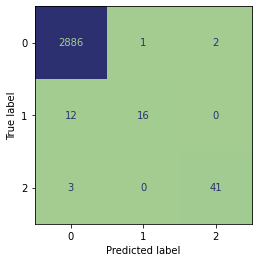

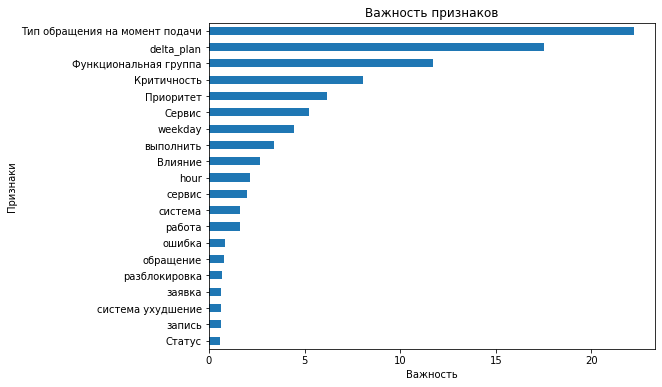

In [457]:
#оценка точности предсказания на отложенной выборке
validation(X_valid, y_valid)

In [458]:
#Предсказание переклассификации для тестового датасета
catc_prediction = catc.predict(test_concat)

Обучение модели предсказания итогового теста

In [460]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(train_concat, 
                                                                train['Тип обращения итоговый'], 
                                                                stratify = train['Тип обращения итоговый'],
                                                                random_state=42, test_size=0.2)

In [461]:
catc = CatBoostClassifier(loss_function = 'MultiClass', #eval_metric= "TotalF1",                       
                          learning_rate=0.1, 
                          max_depth = 2, 
                          #min_data_in_leaf = 10,
                          n_estimators = 5000,
                          #colsample_bylevel = 0.9, 
                          l2_leaf_reg = 1.5,
                          auto_class_weights='Balanced', #'class_weights': (2.09,2.86,0.18,234.5,234.5), 
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU',)
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=cat_features,
         early_stopping_rounds = 50, use_best_model=True, verbose=200)

0:	learn: 0.6400692	test: 0.6426645	best: 0.6426645 (0)	total: 4.05ms	remaining: 20.3s
200:	learn: 0.0897435	test: 0.1651585	best: 0.1649491 (198)	total: 555ms	remaining: 13.2s
400:	learn: 0.0651954	test: 0.1581826	best: 0.1580675 (390)	total: 1.1s	remaining: 12.6s
bestTest = 0.1551462301
bestIteration = 516
Shrink model to first 517 iterations.


In [462]:
catc_prediction1 = catc.predict(test_concat)

In [465]:
#сохранение предсказания для тестовой выборки
create_submission(catc_prediction1, catc_prediction)

### 2. Выявление аномалий

Выявлние аномалий по времени обращения пользователя

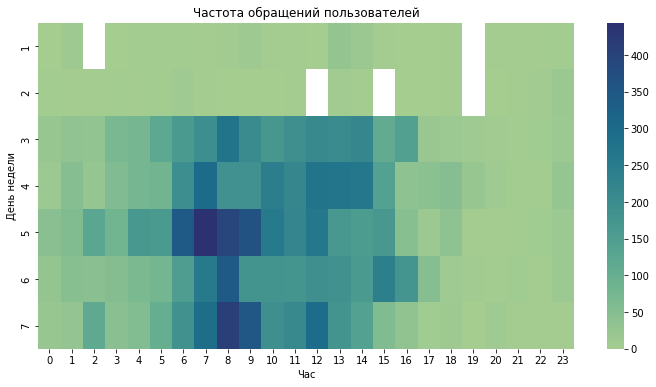

In [438]:
out = train.groupby(['weekday', 'hour'])['Тип обращения итоговый'].sum().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(out, cmap="crest")
plt.title('Частота обращений пользователей')
plt.ylabel('День недели')
plt.xlabel('Час')
plt.show()

Выявление аномалий в числовых данных

In [433]:
#'delta_plan', 'delta_fact', 'delta_real', 'delta_wait'
model=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01), max_features=1.0)
model.fit(train[['delta_fact']])

/home/tanya/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01)

In [434]:
train['delta_fact']=train['delta_fact'].fillna(0).astype(int)
train['scores']=model.decision_function(train[['delta_fact']])
train['anomaly']=model.predict(train[['delta_fact']])
train[(train['anomaly']==-1)][["Содержание", 'Решение             ', 'delta_fact', 'scores', ]].sort_values(by='scores', ascending=True).head(10)

,Содержание,Решение,delta_fact,scores
5622,+Замена клавиатуры для ПЭВМ,Выполнено техническое обслуживание,98,-0.109673
6518,Заявка на предоставление и отзыв прав доступа ...,Работы по обращению выполнены,98,-0.109673
691,Создание запроса,Выполнено,102,-0.109673
9717,Предоставление техники для БРМ,Работы по обращению выполнены,113,-0.109673
4183,Ремонт калорифера (теплообменника) ТТ,Выполнена замена неисправного калорифера,127,-0.109673
5623,+Замена клавиатуры для ПЭВМ,Выполнено техническое обслуживание,98,-0.109673
12255,#отпуск до 13.03##подряд#Пользователи Система160,Пользователю оказана консультация по электронн...,93,-0.109673
8223,65.Устранение ошибки,ПО установлено,78,-0.108497
4688,Создание запроса,Запрос отменён пользователем из портала самооб...,77,-0.106149
4687,Создание запроса,Запрос отменён пользователем из портала самооб...,77,-0.106149


In [284]:
#train[train['anomaly']==-1].index.tolist()

Выявление систем, с наиболее частыми нарушениями

In [351]:
col = ['Тип обращения итоговый', 'Сервис', 'Система', 'Функциональная группа', 'Место']
temp = pd.read_csv('train_dataset_ЦБ/train.csv', sep=',',  na_values="None")[col]

In [352]:
#top_count = temp[temp['Тип обращения итоговый']=='Инцидент']['Сервис'].value_counts(dropna= False)[0:10].to_frame()
#ax = sns.barplot(x="Сервис", data=top_count)

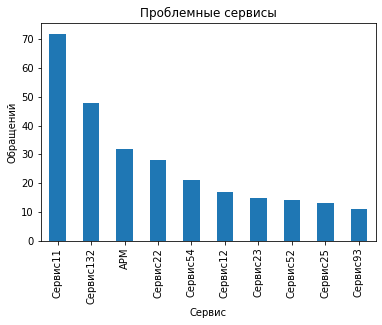

In [354]:
temp[temp['Тип обращения итоговый']=='Инцидент']['Сервис'].value_counts(dropna= False)[0:10].plot(kind='bar')
plt.title('Проблемные сервисы')
plt.ylabel('Обращений')
plt.xlabel('Сервис')
plt.show()

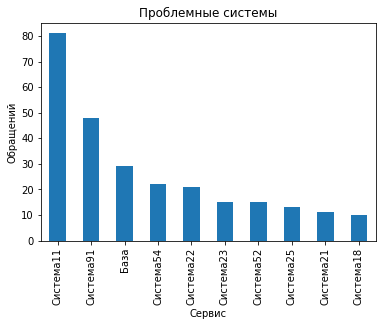

In [355]:
temp[temp['Тип обращения итоговый']=='Инцидент']['Система'].value_counts(dropna= False)[0:10].plot(kind='bar')
plt.title('Проблемные системы')
plt.ylabel('Обращений')
plt.xlabel('Сервис')
plt.show()

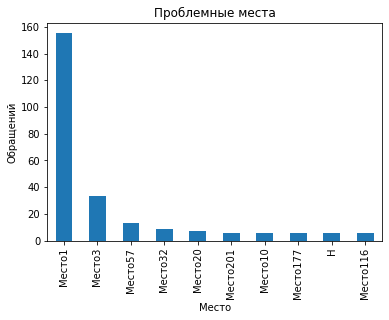

In [356]:
temp[temp['Тип обращения итоговый']=='Инцидент']['Место'].value_counts(dropna= False)[0:10].plot(kind='bar')
plt.title('Проблемные места')
plt.ylabel('Обращений')
plt.xlabel('Место')
plt.show()

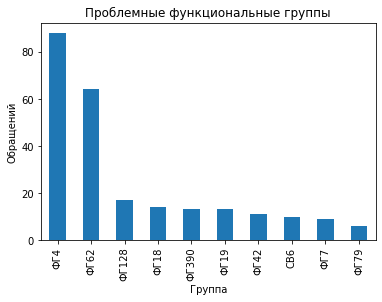

In [357]:
temp[temp['Тип обращения итоговый']=='Инцидент']['Функциональная группа'].value_counts(dropna= False)[0:10].plot(kind='bar')
plt.title('Проблемные функциональные группы')
plt.ylabel('Обращений')
plt.xlabel('Группа')
plt.show()

Выявление аномальных записей

In [435]:
k=5
algo="dbscan"
embeddings=np.asarray(train_concat)
#embeddings=np.asarray(train[columns_name])
kmeans_labels, kmeans_top_texts = clustering(k, algo, train, embeddings)
train['label'] = kmeans_labels

In [436]:
train['label'].value_counts()

-1       7829
 416      112
 203       69
 1671      64
 278       60
         ... 
 849        2
 848        2
 847        2
 846        2
 1892       2
Name: label, Length: 1894, dtype: int64

In [437]:
train[train['label']==-1]['request']

0                                                тест тест
1                                  тестовый обращение тест
2        выполнить разблокировка з region выполнить раз...
3                     включаться пк выход стоя бп замена н
4                        заявка работа обращение выполнить
                               ...                        
14798      разблокировка учётный запись пользователь вс...
14799    устранение уязвимость иб соответствие план вып...
14800    контроль пу заявка доступ порт работа выполнит...
14801                                ремонт стул выполнить
14802    заявка предоставление отзыв право доступ ресур...
Name: request, Length: 7829, dtype: object

### 3.1 Выделение причин нарушений

Выделение ключевых фраз

In [341]:
y = yake.KeywordExtractor(lan="ru",          # язык
                          n = 3,              # максимальное количество слов в фразе
                          dedupLim = 0.2,     # порог похожести слов
                          dedupFunc = 'seqm', #  deduplication algorithm
                          windowsSize = 1,
                          top = 10,           # количество ключевых слов
                          features=None)           

text = " ".join(train[train['Тип обращения итоговый']==0]['request'])    
keywords = y.extract_keywords(text)

#чем ниже показатель, тем релевантнее фраза
pd.DataFrame(keywords, columns=['Фраза', 'Иррелевантность'])

,Фраза,Иррелевантность
0,ухудшение статус сервис,3.064133e-08
1,бот наблюдение система,4.446230e-08
2,сервис самовосстановление бот,1.698483e-07
3,произойти сбой регистрация,3.339967e-06
4,пользователь запрос отмен,3.924148e-06
5,инцидент инцидент инцидент,9.809245e-06
6,система загрузка идентификатор,2.462848e-05
7,зависнуть перезагрузить кнопка,2.572215e-05
8,статус выполняться заявка,2.774915e-05
9,необходимый чистить локальный,3.290571e-05


Наиболее распространенные инциденты и их решение

In [302]:
train[train['Тип обращения итоговый']==0]['Содержание'].value_counts(dropna= False)[0:10]

<Бот-наблюдения> Система91. Ухудшение статуса сервиса.      46
По обращению ************** произошел сбой регистрации      23
<Бот-наблюдения> Система54. Ухудшение статуса сервиса.      21
Не может работать один или несколько Пользователей (...     16
Устранение ошибки                                           15
Система20                                                    9
<Бот-наблюдения> Система23. Ухудшение статуса сервиса.       9
Сообщить об ошибке/неисправности Система18                   8
*****************                                            6
<Бот-наблюдения> Система11. Ухудшение статуса сервиса.       5
Name: Содержание, dtype: int64

In [303]:
train[train['Тип обращения итоговый']==0]['Решение             '].value_counts(dropna=False)[0:10]

Самовосстановление                                                                                               67
Запрос отменён пользователем из портала самообслуживания                                                         34
По заявке ************* создан Инцидент №************                                                            10
Заявка зависла в процессе согласования, выполнен перезапуск, успешно сформирован инцидент №******************     6
самовосстановление                                                                                                6
Гипервизор завис и был перезагружен с кнопки. Работа восстановлена.                                               6
Выполнялась плановая проверка антивирусом                                                                         5
Проблема решена установкой срочного патча  Система11 *******. Необходимо чистить локальный кэш браузера.          4
Установлено/настроено прикладное и офисное ПО                           

#### Можно сделать вывод, что основная причина инцидентов в задаче - ухудшение статуса сервиса. И решается она самовосстановлением или перезагрузкой


![Способ решения проблем](problem.jpg)

### 3.2 Прогноз нарушений

In [403]:
#инцидент 0, Запрос 1
train['count']=1
train['data']=train['Дата обращения'].dt.date
temp = train[['data', 'count','delta_plan']].groupby('data').agg({'count': 'sum','delta_plan': 'median'}).reset_index()
temp0 = train[train['Тип обращения итоговый']==0][['data', 'count','delta_plan']].groupby('data').agg({'count': 'sum','delta_plan': 'median'}).reset_index()
temp1 = train[train['Тип обращения итоговый']==1][['data', 'count','delta_plan']].groupby('data').agg('sum').reset_index()

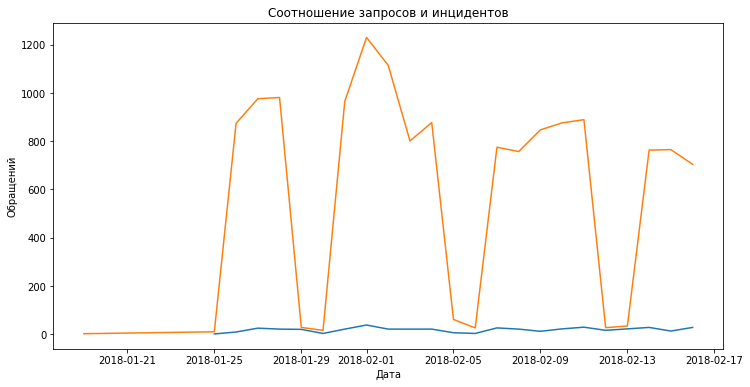

In [404]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(temp0['data'].to_numpy(), temp0['count'].to_numpy())
ax.plot(temp1['data'].to_numpy(), temp1['count'].to_numpy())
plt.title('Соотношение запросов и инцидентов')
plt.ylabel('Обращений')
plt.xlabel('Дата')
plt.show()

Прогноз по инцидентам

In [197]:
#Создаем пустой датафрейм
df_time = pd.DataFrame({'ds': temp0['data'], 
                        'y': temp0['count']})
#df_time['delta_plan'] = temp0['delta_plan']
df_time.head()

,ds,y
0,2018-01-25,1
1,2018-01-26,9
2,2018-01-27,25
3,2018-01-28,21
4,2018-01-29,20


In [201]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=True, changepoint_prior_scale=0.1)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#model.add_regressor('delta_plan')
model.fit(df_time)

09:25:12 - cmdstanpy - INFO - Chain [1] start processing
09:25:12 - cmdstanpy - INFO - Chain [1] done processing


In [202]:
future = model.make_future_dataframe(periods=30)
#future['delta_plan'] = 2
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
47,2018-03-14,36.250108,27.703649,45.342429
48,2018-03-15,30.625554,21.557994,38.996221
49,2018-03-16,29.874870,20.638963,39.013673
50,2018-03-17,36.168158,27.367837,45.101547
51,2018-03-18,37.167903,28.087333,46.053219


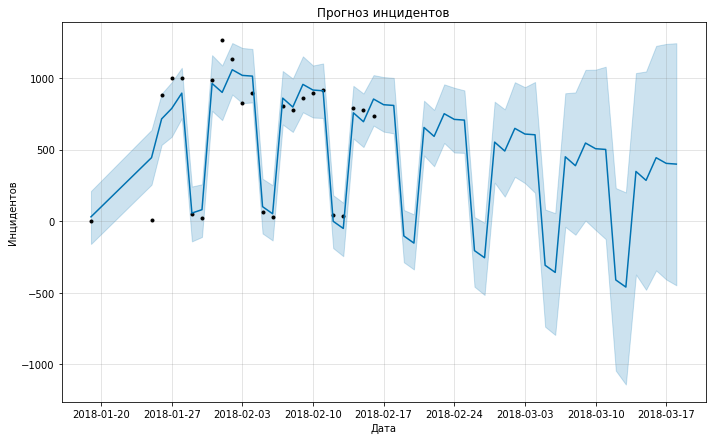

In [411]:
fig1 = model.plot(forecast)
plt.title('Прогноз инцидентов')
plt.ylabel('Инцидентов')
plt.xlabel('Дата')
plt.show()

Прогноз по всем обращениям

In [406]:
#Создаем пустой датафрейм
df_time = pd.DataFrame({'ds': temp['data'], 
                        'y': temp['count']})
#df_time['delta_plan'] = temp0['delta_plan']
df_time.head()

,ds,y
0,2018-01-19,2
1,2018-01-25,11
2,2018-01-26,883
3,2018-01-27,1001
4,2018-01-28,1002


In [407]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=True, changepoint_prior_scale=0.5)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#model.add_regressor('delta_plan')
model.fit(df_time)

11:14:20 - cmdstanpy - INFO - Chain [1] start processing
11:14:20 - cmdstanpy - INFO - Chain [1] done processing


In [408]:
future = model.make_future_dataframe(periods=30)
#future['delta_plan'] = 2
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
49,2018-03-14,347.438969,-372.287874,1034.513992
50,2018-03-15,285.184954,-478.821545,1045.517484
51,2018-03-16,443.484870,-343.940679,1224.264215
52,2018-03-17,403.868108,-407.087712,1237.919204
53,2018-03-18,398.765164,-447.607116,1242.939456


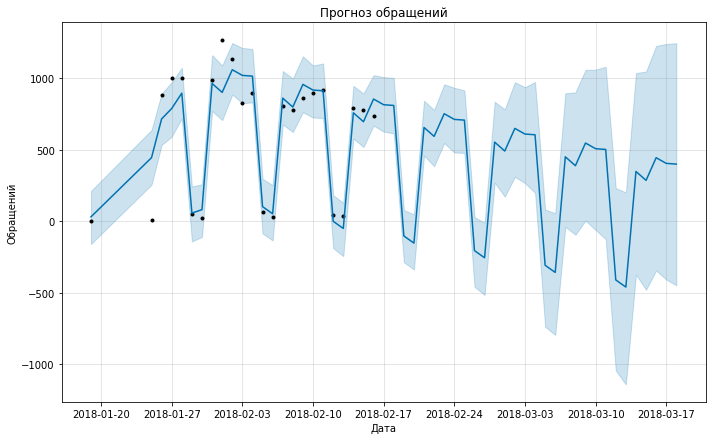

In [410]:
fig1 = model.plot(forecast)
plt.title('Прогноз обращений')
plt.ylabel('Обращений')
plt.xlabel('Дата')
plt.show()